In [1]:
import numpy as np
import pandas as pd
import sys
import json
import os
import copy
import matplotlib.pyplot as plt
import scipy

Make `WMPL` directory visible:

In [2]:
sys.path.append('../../')

Import WMPL files:

In [3]:
import source.WesternMeteorPyLib.wmpl.MetSim.MetSim as metsim
import source.WesternMeteorPyLib.wmpl.MetSim.FitSim as fitsim
import source.WesternMeteorPyLib.wmpl.MetSim.GUI as gui
import source.WesternMeteorPyLib.wmpl.MetSim.MetSimErosion as erosion

Modified version to run with the optimization routine:

In [4]:
class MetSimObj():
    def __init__(self, traj_path, const_json_file, fixed_frag_indices, free_frag_indices):
        # Init an axis for the electron line density
        # self.electronDensityPlot = self.magnitudePlot.canvas.axes.twiny()
        self.electron_density_plot_show = False
        ### Wake parameters ###
        self.wake_on = False
        self.wake_show_mass_bins = False
        self.wake_ht_current_index = 0
        self.current_wake_container = None
        # if self.wake_heights is not None:
        #     self.wake_plot_ht, self.current_wake_container = self.wake_heights[self.wake_ht_current_index]
        # else:
        #     self.wake_plot_ht = self.traj.rbeg_ele # m
        self.wake_normalization_method = 'area'
        self.wake_align_method = 'none'
        self.magnitudePlotWakeLines = None
        self.magnitudePlotWakeLineLabels = None
        self.velocityPlotWakeLines = None
        self.lagPlotWakeLines = None
        self.usg_data, self.traj = gui.loadUSGInputFile(*os.path.split(traj_path))
        self.dir_path = os.path.dirname(traj_path)
        # Disable different density after erosion change
        self.erosion_different_rho = False
        # Disable different ablation coeff after erosion change
        self.erosion_different_sigma = False
        # Disable different erosion coeff after disruption at the beginning
        self.disruption_different_erosion_coeff = False
        # Fragmentation object
        self.fragmentation = None
        self.simulation_results = None
        self.const_prev = None
        self.simulation_results_prev = None
        self.const = erosion.Constants()  # initialize this, these will be replaced later
        self.const.P_0m = self.usg_data.P_0m_bolo
        # If a JSON file with constant was given, load them instead of initing from scratch
        if const_json_file is not None:
            # Load the constants from the JSON files
            self.const, const_json = gui.loadConstants(const_json_file)
            # Init the fragmentation container for the GUI
            if len(self.const.fragmentation_entries):
                self.fragmentation = gui.FragmentationContainer(self, \
                    os.path.join(self.dir_path, self.const.fragmentation_file_name))
                self.fragmentation.fragmentation_entries = self.const.fragmentation_entries
                # Overwrite the existing fragmentatinon file
                # self.fragmentation.writeFragmentationFile()
            # Check if the disruption erosion coefficient is different than the main erosion coeff
            if const_json['disruption_erosion_coeff'] != const_json['erosion_coeff']:
                self.disruption_different_erosion_coeff = True
            # Check if the density is changed after Hchange
            if 'erosion_rho_change' in const_json:
                if const_json['erosion_rho_change'] != const_json['rho']:
                    self.erosion_different_rho = True
            # Check if the ablation coeff is changed after Hchange
            if 'erosion_sigma_change' in const_json:
                if const_json['erosion_sigma_change'] != const_json['sigma']:
                    self.erosion_different_sigma = True
        else:
            raise('no json file!')

        ### Calculate atmosphere density coeffs (down to the bottom observed height, limit to 15 km) ###

        # Determine the height range for fitting the density
        self.dens_fit_ht_beg = self.const.h_init
        self.dens_fit_ht_end = self.traj.rend_ele - 5000
        if self.dens_fit_ht_end < 14000:
            self.dens_fit_ht_end = 14000

        # Fit the polynomail describing the density
        dens_co = gui.MetSimGUI.fitAtmosphereDensity(self, self.dens_fit_ht_beg, self.dens_fit_ht_end)
        self.const.dens_co = dens_co

        # get global parameters from json file, everything other than params marked "free" are fixed
        dt = const_json.get('dt')
        P_0m = const_json.get('P_0m')
        h_init = const_json.get('h_init')
        m_kill = const_json.get('m_kill')
        v_kill = const_json.get('v_kill')
        h_kill = const_json.get('h_kill')
        len_kill = const_json.get('len_kill') 
        rho = const_json.get('rho')  # free
        rho_grain = const_json.get('rho_grain')  # free
        m_init = const_json.get('m_init')  # free
        sigma = const_json.get('sigma')  # free
        v_init = const_json.get('v_init')
        shape_factor = const_json.get('shape_factor')
        gamma = const_json.get('gamma')
        zenith_angle = const_json.get('zenith_angle')
        lum_eff = const_json.get('lum_eff')
        lum_eff_type = const_json.get('lum_eff_type')
        erosion_height_start = const_json.get('erosion_height_start')
        erosion_bins_per_10mass = const_json.get('erosion_bins_per_10mass')
        erosion_coeff = const_json.get('erosion_coeff')
        erosion_height_change = const_json.get('erosion_height_change')
        erosion_coeff_change = const_json.get('erosion_coeff_change')
        erosion_mass_index = const_json.get('erosion_mass_index')
        erosion_mass_min = const_json.get('erosion_mass_min')
        erosion_mass_max = const_json.get('erosion_mass_max')
        erosion_rho_change = const_json.get('rho')
        erosion_sigma_change = const_json.get('sigma')
        compressive_strength = const_json.get('compressive_strength')
        disruption_erosion_coeff = const_json.get('erosion_coeff')
        disruption_mass_grain_ratio = const_json.get('disruption_mass_grain_ratio')
        disruption_mass_index = const_json.get('disruption_mass_index')
        disruption_mass_min_ratio = const_json.get('disruption_mass_min_ratio')
        disruption_mass_max_ratio = const_json.get('disruption_mass_max_ratio')

        # get fragmentation parameters from json file
        # type, height, number, gamma, mass index are fixed, 
        # mass, ablation coefficient, erosion coefficient, grain min, grain max are not fixed
        num_frags = len(const_json.get('fragmentation_entries'))
        # fixed
        frag_types = []
        frag_heights = []
        frag_numbers = []
        frag_ab_coeffs = []
        frag_gammas = []
        frag_mis = []
        # free
        frag_masses = []
        frag_er_coeffs = []
        frag_grain_mins = []
        frag_grain_maxs = []

        for i, frag in enumerate(const_json.get('fragmentation_entries')):
            ### If sigma, gamma and erosiion coefficient are none, convert to whatever the default value is 
            # fixed
            frag_types.append(frag['frag_type'])
            frag_heights.append(frag['height'])
            frag_numbers.append(frag['number'])
            if frag['gamma'] == None:
                frag_gammas.append(gamma)
            else:
                frag_gammas.append(frag['gamma'])
            frag_mis.append(frag['mass_index'])
            if frag['sigma'] == None: 
                frag_ab_coeffs.append(sigma) 
            else:
                frag_ab_coeffs.append(frag['sigma'])
            # free
            frag_masses.append(frag['mass_percent'])
            if frag['erosion_coeff'] == None:
                frag_er_coeffs.append(0.)  # erosion coefficient of zero
            else:
                frag_er_coeffs.append(frag['erosion_coeff'])
            frag_grain_mins.append(frag['grain_mass_min'])
            frag_grain_maxs.append(frag['grain_mass_max'])
            
        # set free and fixed params
        #### CHANGE THESE LINES TO TEST DIFFERENT COMBINATIONS OF FREE PARAMETERS
        self.fixed_frag_indices = fixed_frag_indices
        self.free_frag_indices = free_frag_indices
        # set up masks for free and fixed indices
        free_frag_mask = np.zeros(num_frags, bool)
        free_frag_mask[free_frag_indices] = True  # only free frags
        fixed_frag_mask = np.ones(num_frags, bool)
        fixed_frag_mask[free_frag_indices] = False  # everything EXCEPT free frags (i.e. fixed frags)
        # assign free fixed parameters to object
        self.free_params = [m_init, 
                            list(np.array(frag_masses)[free_frag_mask]), 
                            list(np.array(frag_er_coeffs)[free_frag_mask]), 
                            list(np.array(frag_grain_mins)[free_frag_mask]), 
                            list(np.array(frag_grain_maxs)[free_frag_mask])
                           ]
        self.fixed_params = [dt, P_0m, h_init, m_kill, v_kill, h_kill, len_kill, rho, rho_grain, sigma, 
                             v_init, shape_factor, 
                            gamma, zenith_angle, lum_eff, lum_eff_type, erosion_height_start, 
                            erosion_bins_per_10mass, erosion_coeff, erosion_height_change, 
                            erosion_coeff_change, erosion_mass_index, erosion_mass_min, erosion_mass_max, 
                            erosion_rho_change, erosion_sigma_change, compressive_strength, 
                            disruption_erosion_coeff, disruption_mass_grain_ratio, disruption_mass_index, 
                            disruption_mass_min_ratio, disruption_mass_max_ratio, 
                            frag_types, frag_heights, frag_numbers, 
                            frag_ab_coeffs, frag_gammas, frag_mis,
                            list(np.array(frag_masses)[fixed_frag_indices]), 
                            list(np.array(frag_er_coeffs)[fixed_frag_indices]), 
                            list(np.array(frag_grain_mins)[fixed_frag_indices]), 
                            list(np.array(frag_grain_maxs)[fixed_frag_indices])
                            ]
        
        # load all the global parameters into the object
        consts = dt, P_0m, h_init, m_kill, v_kill, h_kill, len_kill, rho, rho_grain, m_init, sigma, v_init, shape_factor, gamma, zenith_angle, lum_eff, lum_eff_type, erosion_height_start, erosion_bins_per_10mass, erosion_coeff, erosion_height_change, erosion_coeff_change, erosion_mass_index, erosion_mass_min, erosion_mass_max, erosion_rho_change, erosion_sigma_change, compressive_strength, disruption_erosion_coeff, disruption_mass_grain_ratio, disruption_mass_index, disruption_mass_min_ratio, disruption_mass_max_ratio
        self.loadGlobalParameters(consts)

        # get all parameters
        self.all_params = (self.free_params, self.fixed_params)
        
        # self.initializeSimulation(all_params)
        # self.initializeSimulation(const_json)
    
    def loadGlobalParameters(self, consts):
            """
            Loads the global parameters (constants) into the object
            """
            dt, P_0m, h_init, m_kill, v_kill, h_kill, len_kill, rho, rho_grain, m_init, sigma, v_init, shape_factor, gamma, zenith_angle, lum_eff, lum_eff_type, erosion_height_start, erosion_bins_per_10mass, erosion_coeff, erosion_height_change, erosion_coeff_change, erosion_mass_index, erosion_mass_min, erosion_mass_max, erosion_rho_change, erosion_sigma_change, compressive_strength, disruption_erosion_coeff, disruption_mass_grain_ratio, disruption_mass_index, disruption_mass_min_ratio, disruption_mass_max_ratio = consts
            # load all the non-fragmentation parameters into the object
            # 33 parameters
            self.const.dt = dt
            self.const.P_0m = P_0m
            self.const.h_init = h_init
            self.const.m_kill = m_kill
            self.const.v_kill = v_kill
            self.const.h_kill = h_kill
            self.const.len_kill = len_kill
            self.const.rho = rho
            self.const.rho_grain = rho_grain
            self.const.m_init = m_init
            self.const.sigma = sigma
            self.const.v_init = v_init
            self.const.shape_factor = shape_factor
            self.const.gamma = gamma
            self.const.zenith_angle = zenith_angle
            self.const.lum_eff = lum_eff
            self.const.lum_eff_type = lum_eff_type
            self.const.erosion_height_start = erosion_height_start
            self.const.erosion_bins_per_10mass = erosion_bins_per_10mass
            self.const.erosion_coeff = erosion_coeff
            self.const.erosion_height_change = erosion_height_change
            self.const.erosion_coeff_change = erosion_coeff_change
            self.const.erosion_mass_index = erosion_mass_index
            self.const.erosion_mass_min = erosion_mass_min
            self.const.erosion_mass_max = erosion_mass_max
            self.const.erosion_rho_change = erosion_rho_change
            self.const.erosion_sigma_change = erosion_sigma_change
            self.const.compressive_strength = compressive_strength
            self.const.disruption_erosion_coeff = disruption_erosion_coeff
            self.const.disruption_mass_grain_ratio = disruption_mass_grain_ratio
            self.const.disruption_mass_index = disruption_mass_index
            self.const.disruption_mass_min_ratio = disruption_mass_min_ratio
            self.const.disruption_mass_max_ratio = disruption_mass_max_ratio

    def initializeSimulation(self, all_params):
            """ Run the simulation and show the results. """
            # If the fragmentation is turned on and no fragmentation data is given, notify the user
            # if self.const.fragmentation_on and (self.fragmentation is None):
            #     frag_error_message = QMessageBox(QMessageBox.Critical, "Fragmentation file error", \
            #         "Fragmentation is enabled but no fragmentation file is set.")
            #     frag_error_message.setInformativeText("Either load an existing fragmentation file or create a new one.")
            #     frag_error_message.exec_()
            #     return None   

            # unpack all params
            free_params, fixed_params = all_params
            # unpack again
            #### CHANGE THESE NEXT TWO LINES TO TEST DIFFERENT COMBINATIONS OF FREE PARAMETERS
            m_init, frag_masses_free, frag_er_coeffs_free, frag_grain_mins_free, frag_grain_maxs_free = free_params 
            dt, P_0m, h_init, m_kill, v_kill, h_kill, len_kill, rho, rho_grain, sigma, v_init, shape_factor, gamma, zenith_angle, lum_eff, lum_eff_type, erosion_height_start, erosion_bins_per_10mass, erosion_coeff, erosion_height_change, erosion_coeff_change, erosion_mass_index, erosion_mass_min, erosion_mass_max, erosion_rho_change, erosion_sigma_change, compressive_strength, disruption_erosion_coeff, disruption_mass_grain_ratio, disruption_mass_index, disruption_mass_min_ratio, disruption_mass_max_ratio, frag_types, frag_heights, frag_numbers, frag_ab_coeffs, frag_gammas, frag_mis, frag_masses_fixed, frag_er_coeffs_fixed, frag_grain_mins_fixed, frag_grain_maxs_fixed = fixed_params
            # load all the global parameters into the object
            consts = dt, P_0m, h_init, m_kill, v_kill, h_kill, len_kill, rho, rho_grain, m_init, sigma, v_init, shape_factor, gamma, zenith_angle, lum_eff, lum_eff_type, erosion_height_start, erosion_bins_per_10mass, erosion_coeff, erosion_height_change, erosion_coeff_change, erosion_mass_index, erosion_mass_min, erosion_mass_max, erosion_rho_change, erosion_sigma_change, compressive_strength, disruption_erosion_coeff, disruption_mass_grain_ratio, disruption_mass_index, disruption_mass_min_ratio, disruption_mass_max_ratio
            self.loadGlobalParameters(consts)
            # combine free fixed fragmentation parameters
            frag_order = self.fixed_frag_indices + self.free_frag_indices
            frag_masses = np.concatenate((frag_masses_fixed, frag_masses_free))[frag_order]
            frag_er_coeffs = np.concatenate((frag_er_coeffs_fixed, frag_er_coeffs_free))[frag_order]
            frag_grain_mins = np.concatenate((frag_grain_mins_fixed, frag_grain_mins_free))[frag_order]
            frag_grain_maxs = np.concatenate((frag_grain_maxs_fixed, frag_grain_maxs_free))[frag_order]
            
            # Load fragmentation entries
            self.fragmentation_entries = []
            for i in range(0, len(frag_masses)):  # pick any frag entry to iterate over
                frag_entry = gui.FragmentationEntry(frag_types[i], frag_heights[i], frag_numbers[i], frag_masses[i], 
                                                    frag_ab_coeffs[i], frag_gammas[i], frag_er_coeffs[i], frag_grain_mins[i], frag_grain_maxs[i], frag_mis[i])
                self.fragmentation_entries.append(frag_entry)
            # set the fragmentation entries to constants
            self.const.fragmentation_entries = self.fragmentation_entries
    
            # Sort entries by height
            self.fragmentation.sortByHeight()

            # Reset the status of all fragmentations
            self.fragmentation.resetAll()
        
            # fragmentation
            self.const.fragmentation_on = True

            # print(self.const.fragmentation_on)
    
            # Run the simulation
            frag_main, results_list, wake_results = erosion.runSimulation(self.const, compute_wake=self.wake_on)
            # print(results_list)

            # Store simulation results
            self.simulation_results = gui.SimulationResults(self.const, frag_main, results_list, wake_results)


Test with 1999 event:

In [5]:
# metsim_obj_old = MetSimObj_old(traj_path='../usg_metsim_files/1999-01-14/usg_input_jan_1999.txt', 
#                        const_json_file='../usg_metsim_files/1999-01-14/usg_input_jan_1999_sim_fit_latest.json')

In [6]:
FIXED_FRAG_INDICES = [0, 1, 2, 3, 4, 5, 6, 8]
FREE_FRAG_INDICES = [7]  # fragments with free parameters

metsim_obj = MetSimObj(traj_path='../usg_metsim_files/1994-02-01/usg_input_feb_1994.txt', 
                       const_json_file='../usg_metsim_files/1994-02-01/usg_input_feb_1994_sim_fit_latest.json',
                       fixed_frag_indices = FIXED_FRAG_INDICES,
                       free_frag_indices = FREE_FRAG_INDICES
                      )

/home/chowi/Thesis/physical/../../source/WesternMeteorPyLib/wmpl/MetSim/GUI.py:1559: RuntimeWarning: invalid value encountered in log10
  data.absolute_magnitudes = -2.5*np.log10(data.usg_intensity_data[:, 1]/248)


In [7]:
metsim_obj.initializeSimulation(metsim_obj.all_params)

/home/chowi/Thesis/physical/../../source/WesternMeteorPyLib/wmpl/MetSim/GUI.py:95: RuntimeWarning: divide by zero encountered in log10
  self.abs_magnitude_main = -2.5*np.log10(self.luminosity_main_arr/self.const.P_0m)
/home/chowi/Thesis/physical/../../source/WesternMeteorPyLib/wmpl/MetSim/GUI.py:99: RuntimeWarning: divide by zero encountered in log10
  self.abs_magnitude_eroded = -2.5*np.log10(self.luminosity_eroded_arr/self.const.P_0m)


(10.0, 80.0)

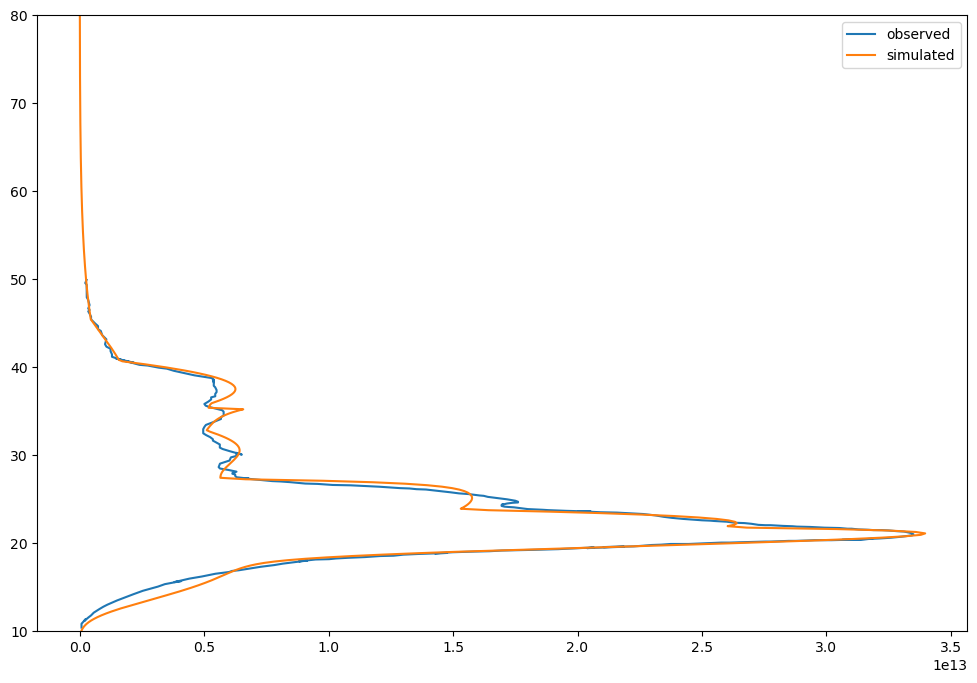

In [8]:
plt.figure(figsize = (12, 8))
plt.plot(3030 * (10 ** (metsim_obj.usg_data.absolute_magnitudes/(-2.5))), metsim_obj.traj.observations[0].model_ht/1000., label = 'observed')
plt.plot(metsim_obj.simulation_results.luminosity_arr, metsim_obj.simulation_results.leading_frag_height_arr/1000., label = 'simulated')
plt.legend()
plt.ylim(10., 80.)

In [9]:
# plt.figure(figsize = (12, 8))
# plt.plot(metsim_obj_old.usg_data.time_data + 11.9, metsim_obj_old.usg_data.absolute_magnitudes, label = 'observed')
# plt.plot(metsim_obj_old.simulation_results.time_arr, metsim_obj_old.simulation_results.abs_magnitude, label = 'simulated')
# plt.legend()

In [10]:
# plt.figure(figsize = (12, 8))
# plt.plot(metsim_obj_old.usg_data.time_data + 11.9, 3030 * (10 ** (metsim_obj_old.usg_data.absolute_magnitudes/(-2.5))), label = 'observed')
# plt.plot(metsim_obj_old.simulation_results.time_arr, metsim_obj_old.simulation_results.luminosity_arr, label = 'simulated')
# plt.legend()
# plt.plot()

In [11]:
# check observed - simulated integrated intensity

obs_integrated_intensity = np.nansum(np.diff(metsim_obj.usg_data.time_data) * 3030 * (10 ** (metsim_obj.usg_data.absolute_magnitudes/(-2.5)))[1:])
sim_integrated_intensity = np.nansum(np.diff(metsim_obj.simulation_results.time_arr) * metsim_obj.simulation_results.luminosity_arr[1:])

obs_integrated_intensity, sim_integrated_intensity

(16731252519886.074, 18190275205937.734)

In [12]:
obs_integrated_intensity - sim_integrated_intensity

-1459022686051.6602

### Optimization:

Note that sometimes MetSim returns a simulated LC in which the height of the leading fragment increases after the end of the LC

In [13]:
# helper nested function to flatten a list

def flatten_list(nested_list):
    def flatten(lst):
        for item in lst:
            if isinstance(item, list):
                flatten(item)
            else:
                flat_list.append(item)

    flat_list = []
    flatten(nested_list)
    return flat_list

# helper function to unflatten the list
#### CHANGE THE NUMBER OF GLOBAL/FRAGMENT PARAMETERS TO TEST DIFFERENT COMBINATIONS
def unflatten_list(lst, num_global_params=1, num_frag_params=4):
    """
    change number of global parameters and frag parameters based on the structure of the free parameters object
    passed into the get_lc_cost_function() function
    """
    # print(lst[:num_global_params], list(zip(*[iter(lst[num_global_params:])]*(len(lst[num_global_params:])//num_frag_params))))
    num_frag_params = max(1, num_frag_params)
    return list(lst[:num_global_params]) + list(zip(*[iter(lst[num_global_params:])]*(len(lst[num_global_params:])//num_frag_params)))


### define residuals for the optimization routine
# TODO: make sure the two are the same size


# def get_lc_residuals(free_params_flattened, metsim_obj):
#     """
#     Gets the residuals for the integrated intensity given a flattened list of free parameters and a metsim object

#     Flattened list of free parameters has the form
#     free_params = [rho, rho_grain, m_init, sigma, *frag_masses, *frag_ab_coeffs, *frag_er_coeffs, *frag_grain_mins, *frag_grain_maxs]

#     Global parameters:
#     rho: float
#     rho_grain: float
#     m_init: float
#     sigma: float

#     Fragment parameters (for n total fragments):
#     *frag_masses: n fragment masses
#     *frag_ab_coeffs: n ablation coefficients
#     *frag_er_coeffs: n erosion coefficients
#     *frag_grain_mins: n grain mins
#     *frag_grain_maxs: n grain maxs
#     """
#     # observed integrated intensity, this doesn't change
#     obs_integrated_intensity = np.nansum(np.diff(metsim_obj.usg_data.time_data) * 
#                                          3030 * (10 ** (metsim_obj.usg_data.absolute_magnitudes/(-2.5)))[1:])
#     # compute the simulated integrated intensity for the given set of free parameters
#     # unflatten the list of free parameters to pass into the initializeSimulation() function
#     free_params = unflatten_list(free_params_flattened)
#     # construct all params to pass into intiializeSimulation function
#     all_params = (free_params, metsim_obj.fixed_params)  # set of all params to use
#     # run simulation
#     metsim_obj.initializeSimulation(all_params)
    
#     # get simulated integrated intensity
#     sim_integrated_intensity = np.nansum(np.diff(metsim_obj.simulation_results.time_arr) * 
#                                          metsim_obj.simulation_results.luminosity_arr[1:])
#     # return the difference between the two
#     return (obs_integrated_intensity - sim_integrated_intensity)

### get the simulated light curve for a given set of free parameters and metsim object

def sim_lc(flattened_free_params, metsim_obj):
    """
    Same format as function below
    """
    # compute the simulated integrated intensity for the given set of free parameters
    # unflatten the list of free parameters to pass into the initializeSimulation() function
    free_params = unflatten_list(flattened_free_params)
    # construct all params to pass into intiializeSimulation function
    # print(free_params)
    all_params = (free_params, metsim_obj.fixed_params)  # set of all params to use
    # run simulation on the object, copying it
    # obj_copy = copy.copy(metsim_obj)
    # obj_copy.initializeSimulation(all_params)
    metsim_obj.initializeSimulation(all_params)
    # return the simulation results
    # return obj_copy.simulation_results
    return metsim_obj.simulation_results


### define cost function for the opitmization routine

def get_lc_cost_function(flattened_free_params, metsim_obj):
    """
    Gets the residuals for the integrated intensity given
    a metsim object and a list/tuple of an initial guess of free parameters
    
    metsim_obj is an MetSim() object
    
    flattened_free_params is an initial guess flattened list of free parameters with the form
    flattened_free_params = [rho, rho_grain, m_init, sigma, *frag_masses, 
    *frag_ab_coeffs, *frag_er_coeffs, *frag_grain_mins, *frag_grain_maxs]

    Global parameters:
    rho: float
    rho_grain: float
    m_init: float
    sigma: float

    Fragment parameters (for n total fragments):
    *frag_masses: n fragment masses
    *frag_ab_coeffs: n ablation coefficients
    *frag_er_coeffs: n - nd erosion coefficients where nd is the number of dust fragments
    (as dust fragments do not have a nassociated erosion coefficient)
    *frag_grain_mins: n grain mins
    *frag_grain_maxs: n grain maxs
    """
    # observed LC intensity, this doesn't change
    obs_lc_intensity = 3030 * (10 ** (metsim_obj.usg_data.absolute_magnitudes/(-2.5)))

    # get simulated LC intensity onthe object
    simulation_results = sim_lc(flattened_free_params, metsim_obj)
    # compute simulated LC intensity
    # find where height starts increasing if it does at any point
    # print(np.diff(simulation_results.leading_frag_height_arr))
    if np.sum(np.diff(simulation_results.leading_frag_height_arr) > 0) > 0:
        first_increasing_height_arr = np.where(np.diff(simulation_results.leading_frag_height_arr) > 0)[0][0] - 1
        print('increasing height')
    else:
        first_increasing_height_arr = -1
    # interpolate to make sure they are the same length and discard points after height starts increasing if it does at any point
    simulated_lc_intensity = np.interp(metsim_obj.traj.observations[0].model_ht, 
                                       np.flip(simulation_results.leading_frag_height_arr[:first_increasing_height_arr]), 
                                       np.flip(simulation_results.luminosity_arr[:first_increasing_height_arr]))
    # return the negative log-likelihood (negative residual sum of square difference between the two)
    # assuming there is no error for the observed LC data
    log_likelihood = (-1/2 * np.nansum((obs_lc_intensity - simulated_lc_intensity) ** 2))/1e24  # scale this
    print(f'negative logL: {-log_likelihood}')
    # negative log lieklihood
    return -log_likelihood

Also need to make sure that the loss function to minimize (currently computed as the **negative** log-likelihood equivalent to negative RSS/$\chi^2$) is correct, since if there are errors then these need to be accounted for in the computation of the loss function

Also probably want to make `sim_lc` returns the interpolated LC:

Test to make sure changing the parameters affects the logL and the LCs:

In [14]:
### USE FOLLOWING LINE TO SAVE NEW SET OF TEST PARAMETERS WHEN TESTING DIFFERENT COMBINATIONS OF PARAMETERS
np.save('initial_guess_1994_TEST.npy', np.array(flatten_list(metsim_obj.free_params)))

In [15]:
initial_guess = np.load('initial_guess_1994_TEST.npy')  # initial pre-saved guess
# initial_guess

lamb_func = lambda free_params_flattened: get_lc_cost_function(free_params_flattened, metsim_obj=metsim_obj)
lamb_func(initial_guess)

negative logL: 166.08079157154498


166.08079157154498

In [16]:
#### USE THIS TO TEST DIFFERENT COMBINATIONS OF TEST PARAMETERS

initial_guess_mod = initial_guess.copy()
# fiddle with global mass
initial_guess_mod[0] = initial_guess[0] + 0.
# fiddle with frag masses
initial_guess_mod = initial_guess + [0., # total mass
                                     10.,  # frag mass pcts
                                     0., # erosion coeffs
                                     0., # grain mins
                                     0.  # grain maxs
                                    ] 

In [17]:
lamb_func(initial_guess_mod)

negative logL: 261.2332923591171


261.2332923591171

In [18]:
results_initial = sim_lc(initial_guess, metsim_obj)
results_initial_mod = sim_lc(initial_guess_mod, metsim_obj)

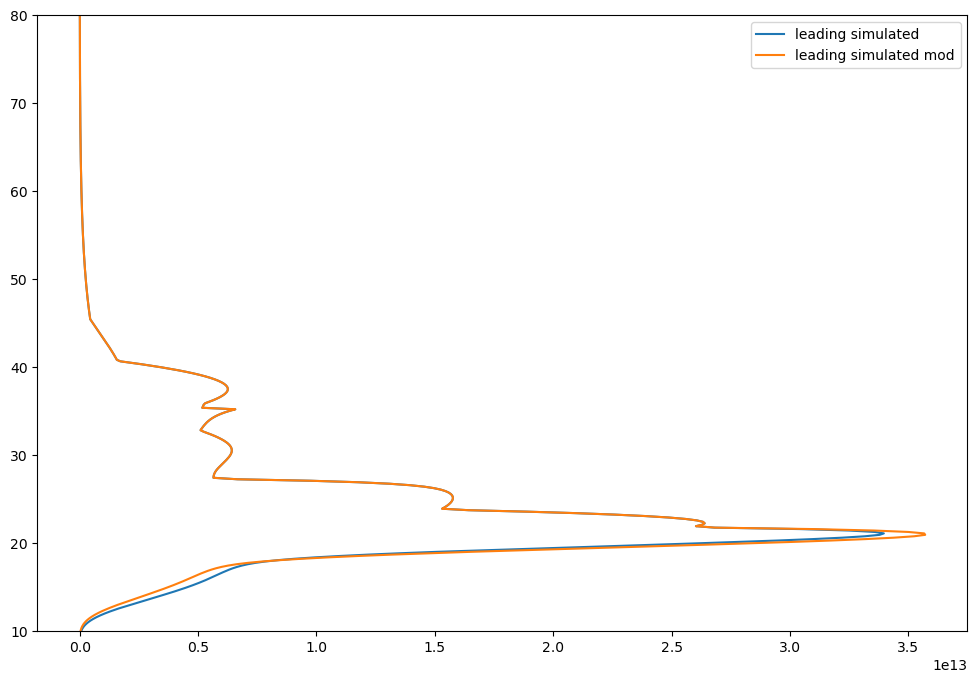

In [19]:
plt.figure(figsize = (12, 8))
plt.plot(results_initial.luminosity_arr, results_initial.leading_frag_height_arr/1000., label = 'leading simulated')
plt.plot(results_initial_mod.luminosity_arr, results_initial_mod.leading_frag_height_arr/1000., label = 'leading simulated mod')
plt.ylim(10., 80.)
plt.legend()

Compute observed LC and simulated initial guess:

In [20]:
# observed LC intensity
obs_lc_intensity = 3030 * (10 ** (metsim_obj.usg_data.absolute_magnitudes/(-2.5)))
# simulated LC intensities
# initial
results_initial = sim_lc(initial_guess, metsim_obj)

Plot simulated initial guess versus observed magnitudes and intensities:

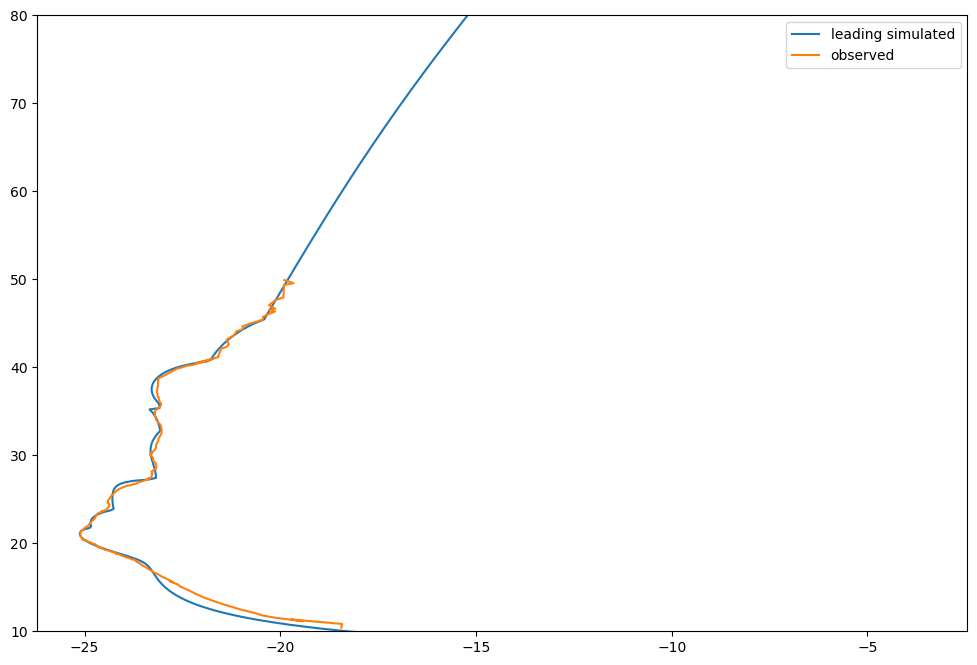

In [21]:
plt.figure(figsize = (12, 8))
plt.plot(results_initial.abs_magnitude, results_initial.leading_frag_height_arr/1000., label = 'leading simulated')
plt.plot(metsim_obj.usg_data.absolute_magnitudes, metsim_obj.traj.observations[0].model_ht/1000., label = 'observed')
plt.ylim(10., 80.)
plt.legend()

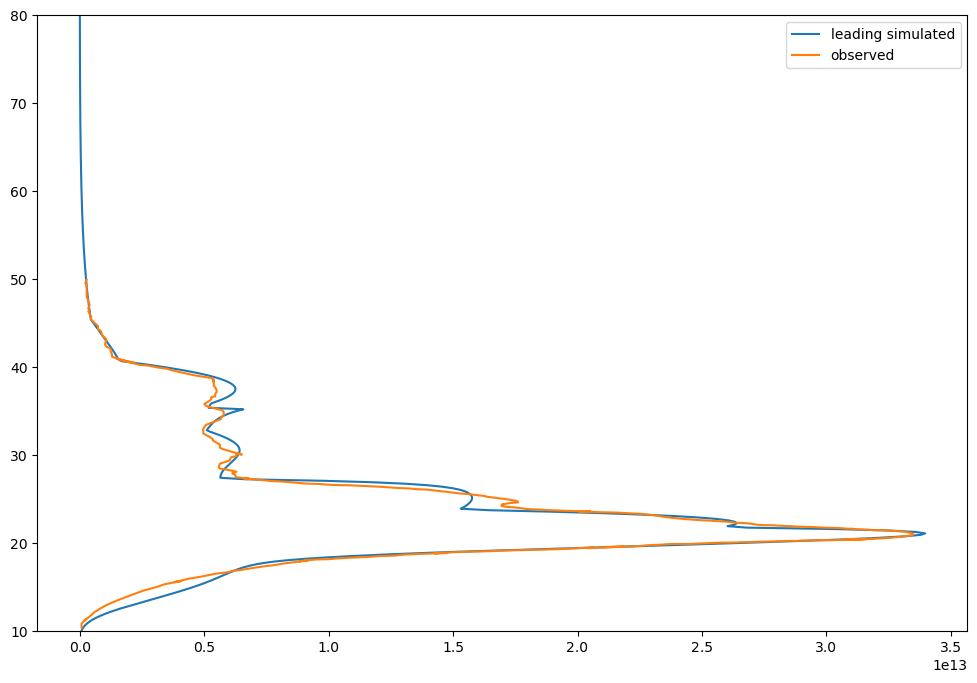

In [22]:
plt.figure(figsize = (12, 8))
# plt.plot(results_initial.luminosity_arr, results_initial.main_height_arr/1000., label = 'main')
# plt.plot(results_initial.luminosity_arr, results_initial.brightest_height_arr/1000., label = 'brightest')
plt.plot(results_initial.luminosity_arr, results_initial.leading_frag_height_arr/1000., label = 'leading simulated')
plt.plot(obs_lc_intensity, metsim_obj.traj.observations[0].model_ht/1000., label = 'observed')
plt.ylim(10., 80.)
plt.legend()

Run optimization:

    flattened_free_params is an initial guess flattened list of free parameters with the form
    flattened_free_params = [m_init, *frag_masses, *frag_er_coeffs, *frag_grain_mins, *frag_grain_maxs]

    Global parameters:
    m_init: float --> (1e4, 1e7) # wide range for initialm ass

    Fragment parameters (for n total fragments):
    *frag_masses: n fragment masses --> (0, 100) %
    *frag_er_coeffs: n erosion coefficients --> (0.23, 6) for eroding fragments based on danielle's cases
                                                 0 for dust also based on danielle
    *frag_grain_mins: n grain mins --> (1e-8, 1e-2) for eroding fragments (use same for dust) based on danielle
    *frag_grain_maxs: n grain maxs --> (5e-7, 5e0) for eroding fragments (use same for dust) based on danielle

In [23]:
# Generate the tuples based on the length of free fragments
fragmentation_count = len(FREE_FRAG_INDICES)
# Fragment mass percents
frag_mass_percents = tuple((0., 100.) for _ in range(fragmentation_count))
# Frag ablation coeffs
# these are 0.01 for dust and between (0.002 * 1e-6, 0.025 * 1e-6) for eroding fragments
# frag_ablation_coeffs = tuple((0.002 * 1e-6, 0.025 * 1e-6) for _ in range(fragmentation_count))
# frag_ablation_coeffs = tuple([(0.01 * 1e-6, 0.01 * 1e-6) if entry.frag_type == 'D'
#                               else (0.002 * 1e-6, 0.025 * 1e-6) for entry in metsim_obj.fragmentation_entries])
# Frag erosion coeffs
# these are fixed at zero for dust and between (0.23 * 1e-6, 6.0 * 1e-6) for eroding fragments
# frag_erosion_coeffs = tuple([(0., 0.) if entry.frag_type == 'D' 
#                              else (0.23 * 1e-6, 6.0 * 1e-6) for entry in metsim_obj.fragmentation_entries])
frag_erosion_coeffs = tuple([(0., 0.) if entry.frag_type == 'D' 
                             else (0.1 * 1e-6, 6.0 * 1e-6) for entry in 
                             [metsim_obj.fragmentation_entries[i] for i in FREE_FRAG_INDICES]])
# frag_erosion_coeffs = tuple((0.23 * 1e-6, 6.0 * 1e-6) for _ in range(fragmentation_count))
# Frag grain mins
# frag_grain_mins = tuple((1e-8, 1e-2) for _ in range(fragmentation_count))
frag_grain_mins = tuple((1e-4, 1e1) for _ in range(fragmentation_count))
# Frag grain maxs
frag_grain_maxs = tuple((1e-3, 1e2) for _ in range(fragmentation_count))
# Combine them into a single flat tuple
#### CHANGE THE RESULTS/BOUNDS DEPENDING ON WHAT COMBINATION IS BEING USED!
result = frag_mass_percents + frag_erosion_coeffs + frag_grain_mins + frag_grain_maxs
# Print the result to check the output
bounds = ((10 ** 4, 10 ** 7), ) + result

# run optimization routine

# constraints
# def apply_mass_constraint(flattened_free_params):
#     """
#     Restrict grain max to be greater than grain min, otherwise MetSim crashes
#     """
#     unflattened_list = unflatten_list(flattened_free_params)
#     frag_grain_mins = unflattened_list[-2]  # get grain mins
#     frag_grain_maxs = unflattened_list[-1]   # get grain maxs
#     ## EQUALITY
#     # return 0 if optimizer should accept as valid value, return 1 if it should reject
#     return np.sum(list(map(lambda min, max: min > max, frag_grain_mins, frag_grain_maxs)))
#     ## INEQUALITY
#     # return -np.sum(list(map(lambda min, max: min > max, frag_grain_mins, frag_grain_maxs)))

# mass_constraint = ({'type': 'eq', "fun": lambda flattened_free_params[})

#### ADD MASS CONSTRAINTS IF GRAIN MIN/MAX IS BEING USED IN THE COMBINATIONS!
# generate mass constraints
mass_constraints = []
# for each fragment, impose constraint that the fragment grain min (position -2) must be less than the fragment grain max (position -1)
for i in range(len(unflatten_list(initial_guess)[-1])):
    mass_constraints.append({'type': 'eq', 
                             "fun": lambda free_params_flattened: 
                             int(unflatten_list(free_params_flattened)[-2][i] > unflatten_list(free_params_flattened)[-1][i])})

Run optimization:

$\sim 90$ minutes for $200$ iterations

Seems to stabilize after $\sim 35$ iterations at whatever value...

In [25]:
import time
import warnings

class TookTooLong(Warning):
    pass

class MinimizeStopper(object):
    def __init__(self, max_sec=60):
        self.max_sec = max_sec
        self.start = time.time()
    def __call__(self, xk=None):
        elapsed = time.time() - self.start
        if elapsed > self.max_sec:
            warnings.warn("Terminating optimization: time limit reached",
                          TookTooLong)
        else:
            # you might want to report other stuff here
            print("Elapsed: %.3f sec" % elapsed)

best_fit = scipy.optimize.minimize(fun=lambda free_params_flattened: 
                                   get_lc_cost_function(free_params_flattened, metsim_obj=metsim_obj),
                                   x0=initial_guess_mod, 
                                   method='trust-constr',
                                   # method='L-BFGS-B',
                                   # method='SLSQP',
                                   # method='BFGS',
                                   # method='Nelder-Mead',
                                   bounds=bounds, 
                                   options={'verbose': 2, 
                                            'maxiter': 50, 
                                            # 'gtol': 9e-1
                                            # 'return_all': True,
                                           },
                                   constraints=mass_constraints, 
                                   # callback=MinimizeStopper()
                                  )#, options={'maxiter': 1e5})

negative logL: 261.2332923591171
negative logL: 261.2333025761027
negative logL: 261.2332918651992
negative logL: 327.37863054843456
negative logL: 261.2332923591171
negative logL: 261.23331105806074
| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   6   |   0   | +2.6123e+02 | 1.00e+00 | 1.48e+09 | 0.00e+00 |
negative logL: 1709.6024322558083
negative logL: 1709.6024034719676
negative logL: 1709.6024342564833
negative logL: 1709.6024322558083
negative logL: 1709.6024322558083
negative logL: 1709.6024322558083
|   2   |  12   |   1   | +1.7096e+03 | 1.00e+00 | 2.98e+00 | 3.46e-01 |


/home/chowi/miniconda3/envs/wmpl/lib/python3.8/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


negative logL: 1709.6073099703638
negative logL: 1709.6071099771978
negative logL: 1709.607311971504
negative logL: 1709.6073099703638
negative logL: 1709.6073099703638
negative logL: 1709.6073099703638
|   3   |  18   |   4   | +1.7096e+03 | 7.00e+00 | 2.98e+00 | 2.94e-01 |
negative logL: 1709.5906553545797
negative logL: 1709.5906191342774
negative logL: 1709.5906569995916
negative logL: 1709.5906553545797
negative logL: 1709.5906553545797
negative logL: 1709.5906553545797
|   4   |  24   |   8   | +1.7096e+03 | 7.81e+00 | 2.45e+00 | 1.66e-01 |
negative logL: 1709.5899959068993
negative logL: 1709.5899557225273
negative logL: 1709.589997907333
negative logL: 1709.5899959068993
negative logL: 1709.5899959068993
negative logL: 1709.5899959068993
|   5   |  30   |  12   | +1.7096e+03 | 7.84e+00 | 2.98e+00 | 8.34e-02 |
negative logL: 1709.589603569145
negative logL: 1709.58956338471
negative logL: 1709.5896055693927
negative logL: 1709.589603569145
negative logL: 1709.589603569145
negati

In [26]:
best_fit

           message: The maximum number of function evaluations is exceeded.
           success: False
            status: 0
               fun: 217.64352695630348
                 x: [ 1.500e+06  4.502e+01  1.000e-07  9.721e-01  3.226e+00]
               nit: 50
              nfev: 360
              njev: 60
              nhev: 0
          cg_niter: 126
      cg_stop_cond: 2
              grad: [ 2.507e-04  2.950e-01  4.574e+09  0.000e+00  2.532e+02]
   lagrangian_grad: [ 2.507e-04  2.944e-01  0.000e+00 -4.433e-02  2.310e+02]
            constr: [array([0]), array([ 1.500e+06,  4.502e+01,  1.000e-07,  9.721e-01,
                            3.226e+00])]
               jac: [array([[ 0.000e+00,  0.000e+00,  0.000e+00,
                             0.000e+00,  0.000e+00]]), array([[ 1.000e+00,  0.000e+00, ...,  0.000e+00,
                             0.000e+00],
                           [ 0.000e+00,  1.000e+00, ...,  0.000e+00,
                             0.000e+00],
                   

In [27]:
initial_guess, best_fit.x

(array([1.5e+06, 3.5e+01, 1.0e-07, 1.0e+00, 5.0e+00]),
 array([1.50000000e+06, 4.50206262e+01, 1.00048064e-07, 9.72058568e-01,
        3.22641196e+00]))

In [28]:
np.save('best_fit_1994_mod_start.npy', best_fit)

Compare original LC to simulated LCs with the initial guess and the best-fit guess:

In [29]:
results_initial = sim_lc(initial_guess, metsim_obj)

In [30]:
# best fit
results_bf = sim_lc(best_fit.x, metsim_obj)

Plot:

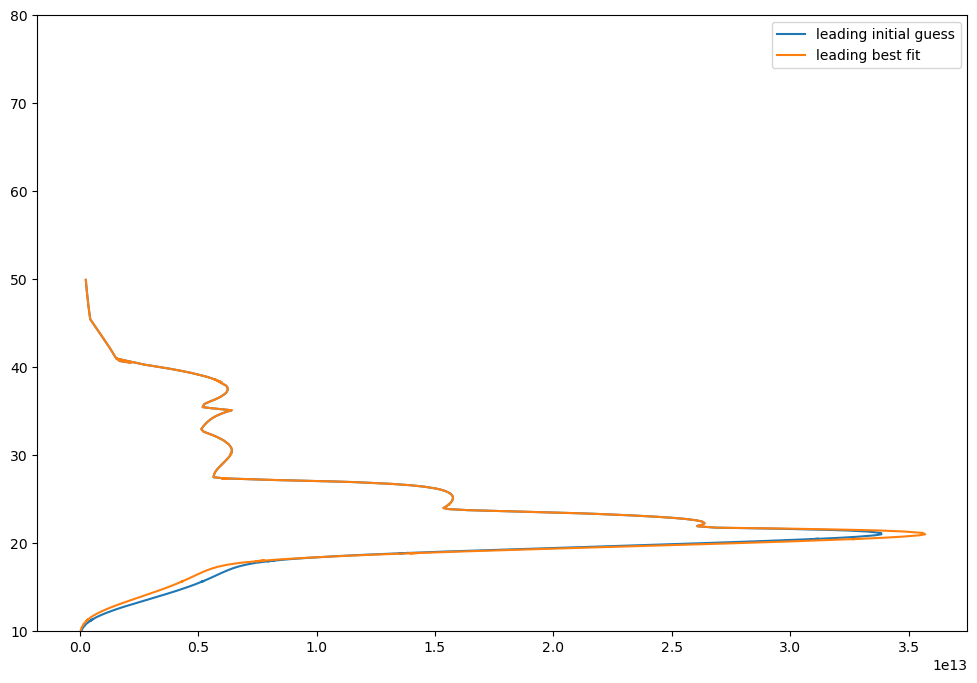

In [31]:
plt.figure(figsize = (12, 8))
# plt.plot(obs_lc_intensity, metsim_obj.traj.observations[0].model_ht/1000., label = 'observed')
# interpolate the results initial and results leading frag heights
if np.sum(np.diff(results_initial.leading_frag_height_arr) > 0) > 0:
    first_increasing_height_arr = np.where(np.diff(results_initial.leading_frag_height_arr) > 0)[0][0] - 1
else:
    first_increasing_height_arr = -1
interpolated_initial_int = np.interp(metsim_obj.traj.observations[0].model_ht, 
          np.flip(results_initial.leading_frag_height_arr[:first_increasing_height_arr]), 
          np.flip(results_initial.luminosity_arr[:first_increasing_height_arr]))
interpolated_bf_int = np.interp(metsim_obj.traj.observations[0].model_ht, 
          np.flip(results_bf.leading_frag_height_arr[:first_increasing_height_arr]), 
          np.flip(results_bf.luminosity_arr[:first_increasing_height_arr]))

plt.plot(interpolated_initial_int, metsim_obj.traj.observations[0].model_ht/1000., label = 'leading initial guess')
plt.plot(interpolated_bf_int, metsim_obj.traj.observations[0].model_ht/1000., label = 'leading best fit')
# plt.plot(results_initial.luminosity_arr, results_initial.leading_frag_height_arr/1000., label = 'leading initial guess')
# plt.plot(results_bf.luminosity_arr, results_bf.leading_frag_height_arr/1000., label = 'leading best fit')
plt.ylim(10., 80.)
plt.legend()

Compare the cost function (RSS):

In [32]:
get_lc_cost_function(best_fit.x, metsim_obj), get_lc_cost_function(initial_guess, metsim_obj)

negative logL: 217.64352695630348
negative logL: 166.08079157154498


(217.64352695630348, 166.08079157154498)

Height of leading fragment: